### MacOSx Bugfix
Execute the following 2 instructions in console before starting the Ipython server:

In [384]:
%matplotlib inline

### Dependencies

In [385]:
import sys
import os

import csv
import numpy as np
import matplotlib.pyplot as plt

# 1. Parser Code

In [386]:
def parseFiles(root,verbose=False):
    """
    returns a dictionary with the following format:
    -> filename string as a key.
    -> float 'tuple' (train_acc, test_acc, time); containing the parsed values.    
    i.e.
      d[file][0] := Train Accuracy
      d[file][1] := Test Accuracy
      d[file][2] := Elapsed time
    """
    d={} # init empty dictionary
    for folder, subdirs, files in os.walk(root):
        for fname in files:
            if fname.endswith('.txt'):
                rpath = os.path.join(folder,fname)
                f = open(rpath,'r')
                lines = f.readlines()

                train_acc = lines[-3].split()[-6][:-1]  # train accuracy token
                test_acc = lines[-3].split()[-1]        # test accuracy token
                time = lines[-2].split()[-2]            # elapsed time token 
                
                if '500-500-500' in rpath:
                    # Now modificated to contain hyperparams...
                    p0 = tuple(lines[5].split()[-2:])
                    ptflag = lines[6].split()[-1]
                    if ptflag == 'true':
                        p1 = tuple(['PT Epochs', int(lines[7].split()[-1])])
                        p2 = tuple(['PT LearningRate', float(lines[8].split()[-1])])
                    else:
                        p1 = tuple(['PT Epochs', None])
                        p2 = tuple(['PT LearningRate', None])
                    p3 = tuple(['FT Epochs', int(lines[10].split()[-1])])
                    p4 = tuple(['FT LearningRate', float(lines[11].split()[-1])])    
                    d[rpath] = (np.float(train_acc), np.float(test_acc), np.float(time), [p0,p1,p2,p3,p4])
                
                else:
                    d[rpath] = (np.float(train_acc), np.float(test_acc), np.float(time))

                if(verbose):
                    print rpath
                    print '  Train Accuracy',train_acc
                    print '  Test Accuracy',test_acc
                    print '  Elapsed time',time,'\n'
    return d

def rank(d, top=None):
    if top==None:
        top = len(d)
    return sorted(d.items(), key=lambda x: x[1][1], reverse=True)[:top]

### Show N best results

In [387]:
N = 10
root = '.'+os.path.sep+'results'

d = parseFiles(root); # order files by its accuracy
ranked = rank(d,N) # 10 best results

print "\nTop\t\tTest Accuracy\tTrain Accuracy\tElapsed Time\tFile"
print "-----\t\t--------------\t-------------\t-------------\t------"
for idx, val in enumerate(ranked):
    print idx+1,'\t\t',val[1][1],'\t\t',val[1][0],'\t\t',val[1][2],'\t',val[0]


Top		Test Accuracy	Train Accuracy	Elapsed Time	File
-----		--------------	-------------	-------------	------
1 		0.9707 		1.0 		96.297238 	./results/MLP/500_50/DeepBPN_MLP_Epochs_100.txt
2 		0.9706 		1.0 		95.868413 	./results/MLP/200_200/DeepBPN_MLP_Epochs_100.txt
3 		0.9706 		1.0 		96.385644 	./results/MLP/50_50/DeepBPN_MLP_ReducedData_10000.txt
4 		0.9706 		1.0 		107.153244 	./results/MLP/500_200_200/DeepBPN_MLP_LearningRate_2.000000e-01.txt
5 		0.9705 		1.0 		480.495128 	./results/MLP/500_50/DeepBPN_MLP_Epochs_500.txt
6 		0.9704 		1.0 		100.778618 	./results/MLP/50_50/DeepBPN_MLP_Epochs_100.txt
7 		0.9702 		1.0 		192.323538 	./results/MLP/200_50/DeepBPN_MLP_Epochs_200.txt
8 		0.97 		1.0 		97.45605 	./results/MLP/500_200/DeepBPN_MLP_LearningRate_2.000000e-01.txt
9 		0.9698 		1.0 		192.282871 	./results/MLP/500_50/DeepBPN_MLP_Epochs_200.txt
10 		0.9697 		1.0 		109.88163 	./results/MLP/500_200_50/DeepBPN_MLP_Epochs_100.txt


# 2. Export to CSV
Useful to auto-generate Latex tables

In [388]:
def generateCSV(d, filename=None):
    '''
    assume tab \t as the delimiter
    '''
    with open('./csv/'+filename+'.csv', 'wb') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter='\t')
        spamwriter.writerow(['Topology','Parameter','Train Accuracy','Test Accuracy','Elapsed Time'])
        if isinstance(d, dict):
            for key in data:
                spamwriter.writerow(getFilenameResume(key)+list(d[key]))
        elif isinstance(d, list):
            for item in d:
                spamwriter.writerow(getFilenameResume(item[0])+[item[1][0],item[1][1],round(item[1][2],2)])
        else:
            print('Unsupported type')
            return
        
def getFilenameResume(filename):
    clean = filename[14:-4].replace('DeepBPN','').replace('_',' ').split(os.path.sep)
    param = clean[1][1:].split(' '); 
    
    try:
        num = int(param[-1])
    except:
        try:
            num = float(param[-1])
        except:
            num = bool(param[-1]) # here we suppose it must be true! (or false)      
    #print [clean[0],' '.join(param[:2]+[str(num)])]
    return [clean[0],' '.join(param[:2]+[str(num)])]


def generateCompleteCSV(d, filename=None):
    '''
    assume tab \t as the delimiter
    '''
    with open('./csv/'+filename+'.csv', 'wb') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter='\t')
        spamwriter.writerow(['Id']+[param[0] for param in d[0][1][3]]+['Train Acc','Test Acc','Time'])
        if isinstance(d, list):
            Id = 0
            for item in d:
                spamwriter.writerow([Id]+[param[1] for param in item[1][3]]+[item[1][0],item[1][1],round(item[1][2],2)])
                Id = Id + 1
        else:
            print('Unsupported type')
            return

### Let's generate a CSV file for each RBM/MLP/BOTH results

In [389]:
N = 10
r1 = '.'+os.path.sep+'results'

# ALL (MLP + RBM)
d = parseFiles(r1); # order files by its accuracy
ranked = rank(d)
generateCSV(ranked[:N],'top'+str(N)+'_ALL')
generateCSV(ranked[-N:],'worst'+str(N)+'_ALL')

# just MLP
d = parseFiles(r1+os.path.sep+'MLP'); # order files by its accuracy
ranked = rank(d)
generateCSV(ranked[:N],'top'+str(N)+'_MLP')
generateCSV(ranked[-N:],'worst'+str(N)+'_MLP')

# just RBM
d = parseFiles(r1+os.path.sep+'RBM'); # order files by its accuracy
ranked = rank(d)
generateCSV(ranked[:N],'top'+str(N)+'_RBM')
generateCSV(ranked[-N:],'worst'+str(N)+'_RBM')

# complete hyper-param test
r2 = '.'+os.path.sep+'500-500-500'
d = parseFiles(r2);
ranked = rank(d)
generateCompleteCSV(ranked,'RBMfullTable')

# 3. Visualization Code

### Plot example

In [390]:
x = np.linspace(0, 3*np.pi, 500)
plt.plot(x, np.sin(x**2))
plt.title('A simple chirp')
plt.show()

## Bar Plot generation

In [394]:
def getNumber(string, key):
    phrase = key.split(string + "_")[1]
    phrase = phrase[0:-4]
    try:
        num = int(phrase)
    except:
        num = float(phrase)
    return num

def plotParameter(tupla, parameter, colors):
    width = 0.70       # the width of the bars: can also be len(x) sequence
    test = [x[1] for x in tupla]
    train = [x[2] for x in tupla]    
    labels = [x[0] for x in tupla]
    ind = np.arange(len(test))
    p1 = plt.bar(ind, train, width, color=colors[0])
    p2 = plt.bar(ind, test, width, color=colors[1])
    plt.ylabel('Accuracy')
    plt.xlabel(parameter)
    plt.xticks(ind + width/2., labels)
    plt.ylim(min(test)-0.05,1)
    plt.legend((p1[0], p2[0]), ('Train', 'Test'))

#########################
# Multi Layer Perceptron
#########################
def plotTopologyMLP(root,net,d):
    epoch = []
    learnRate = []
    redData = []
    for key, value in d.iteritems():
        if "Epochs" in key:
            epoch.append((getNumber("Epochs", key),value[1], value[2]))
        elif "LearningRate" in key:
            learnRate.append((getNumber("LearningRate", key), value[1], value[2]))
        elif "ReducedData" in key:
            redData.append((getNumber("ReducedData", key), value[1], value[2]))

    epoch.sort(key=lambda x: x[0])
    learnRate.sort(key=lambda x: x[0])
    redData.sort(key=lambda x: x[0])
    
    colors = ('y','r')
    fig = plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plotParameter(epoch, "Epochs", colors)
    plt.subplot(1,3,2)
    plotParameter(learnRate, "Learning Rate", colors)
    plt.subplot(1,3,3)
    plotParameter(redData, "Reduced Data", colors)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    name = root[10:].replace(os.path.sep,"_")
    n = name.replace(net,"")
    n = n.replace("_"," ")
    plt.suptitle('Topology:'+n,fontsize=20)
    
    # check whether path already exists or not
    path = "figures"+os.path.sep+"MLP"
    if not os.path.exists(path):
        os.makedirs(path)
    
    filename = path+os.path.sep+name
    fig.savefig(filename);
    saveLatex(name, "MLP")

################################
# Restricted Boltzmann Machines
################################
def plotTopologyRBM(root,net,d):
    FTepoch = []
    PTepoch = []
    PTlearnRate = []
    FTlearnRate = []
    redData = []
    for key, value in d.iteritems():
        if "FineTuningEpochs" in key:
            FTepoch.append((getNumber("FineTuningEpochs", key),value[1], value[2]))
        elif "PreTrainingEpochs" in key:
            PTepoch.append((getNumber("PreTrainingEpochs", key),value[1], value[2]))
        elif "PreTrainingLearningRate" in key:
            PTlearnRate.append((getNumber("PreTrainingLearningRate", key), value[1], value[2]))
        elif "FineTuningLearningRate" in key:
            FTlearnRate.append((getNumber("FineTuningLearningRate", key), value[1], value[2]))
        elif "ReducedData" in key:
            redData.append((getNumber("ReducedData", key), value[1], value[2]))

    PTepoch.sort(key=lambda x: x[0])
    FTepoch.sort(key=lambda x: x[0])
    PTlearnRate.sort(key=lambda x: x[0])
    FTlearnRate.sort(key=lambda x: x[0])
    redData.sort(key=lambda x: x[0])
    
    colors = ('g','b')
    fig = plt.figure(figsize=(8,10))
    plt.subplot(3,2,1)
    plotParameter(FTepoch, "Fine-Tuning Epochs",colors)
    plt.subplot(3,2,2)
    plotParameter(FTlearnRate, "Fine-Tuning Learning Rate", colors)
    plt.subplot(3,2,3)
    plotParameter(PTepoch, "Pre-Train Epochs", colors)
    plt.subplot(3,2,4)
    plotParameter(PTlearnRate, "Pre-Train Learning Rate", colors)
    plt.subplot(3,2,5)
    plotParameter(redData, "Reduced Data", colors)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    name = root[10:].replace(os.path.sep,"_")
    n = name.replace(net,"")
    n = n.replace("_"," ")
    plt.suptitle('Topology:'+n,fontsize=20)
    
    # check whether path already exists or not
    path = "figures"+os.path.sep+"RBM"
    if not os.path.exists(path):
        os.makedirs(path)
        
    filename = path+os.path.sep+name
    fig.savefig(filename);
    saveLatex(name, "RBM")

##################################################
# create ALL bar plots used in the final report
##################################################    
def generateBarPlots(root):
    nets = os.listdir(root)
    for net in nets:
        path = root+os.path.sep+net
        for folder, subdirs,files in os.walk(path):
            if (folder != path) and (folder!= root):
                d = parseFiles(folder); # order files by its accuracy
                if net == "MLP":
                    plotTopologyMLP(folder,net,d)
                elif net == "RBM":
                    if "-" not in folder:
                        plotTopologyRBM(folder,net,d)
                else:
                    print "ERROR"
                    break

def generateLinePlots(root):
    d = parseFiles(root);
    ranked = rank(d)
    for i,val in enumerate(ranked):
        ranked[i] = (int(val[0].split('_')[-1][:-4]), val[1])

    trn_acc = [x[1][0] for x in ranked]
    tst_acc = [x[1][1] for x in ranked]
    el_time = [x[1][2] for x in ranked]

    fig1 = plt.figure(figsize=(15,4))
    p1 = plt.plot(trn_acc)  # test acc
    p2 = plt.plot(tst_acc)  # train acc
    plt.title('RBM Accuracy resume',fontsize=20)
    plt.ylim(min(tst_acc), 1.01)
    plt.xlim(0, len(ranked))
    plt.xticks(range(0,270,10))
    plt.ylabel('Accuracy')
    plt.xlabel('Execution Id.')
    plt.legend((p1[0], p2[0]), ('Test', 'Train'), loc='lower left')
    plt.show()

    fig2 = plt.figure(figsize=(15,4))
    p1 = plt.plot(el_time, color='r')  # elapsed time
    plt.title('RBM Elapsed Time resume',fontsize=20)
    plt.ylim(min(el_time), max(el_time))
    plt.xlim(0,len(ranked))
    plt.xticks(range(0,270,10))
    plt.yticks(range(100,int(max(el_time))+1,250))
    plt.ylabel('Time (sec.)')
    plt.xlabel('Execution Id.')
    plt.show()
    
    # check whether path already exists or not
    path = "figures"+os.path.sep+"RBM"
    if not os.path.exists(path):
        os.makedirs(path)
        
    fig1.savefig(path+os.path.sep+'acc-plot');
    fig2.savefig(path+os.path.sep+'time-plot');               
                    
## SAVE LATEX FORMAT
def saveLatex(name, net):
    f = open("figures/" + net + "/" "latexFormat.txt", 'a')
    f.write("\\begin{figure}[H]\n")
    f.write("\t\\centering\n")
    f.write("\t\\includegraphics[scale=0.6]{Figures/"+net+"/"+name + ".png}" + "\n")
    n = name.replace(net,"")
    n = n.replace("_"," ")
    
    f.write("\t\\caption{Accuracy of the different parameters for the network " + 
            net +" with topology ["+ n+"]}\n")
    f.write("\t\\label{plot_" + name +"}\n") 
    f.write("\\end{figure}\n")
    f.write("\n\n")
    f.close()

### Let's generate all plots

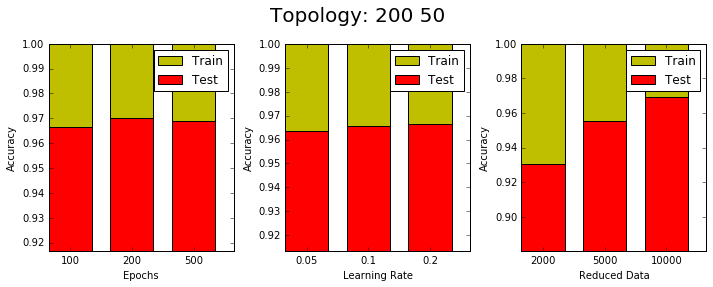

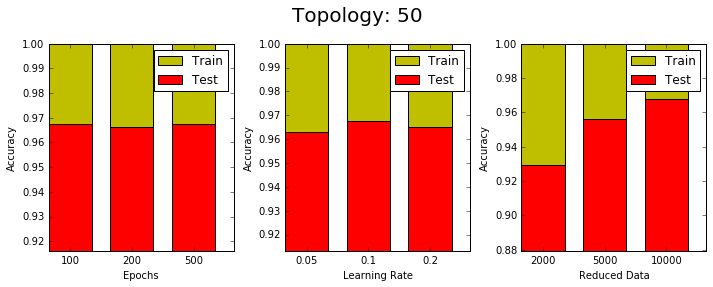

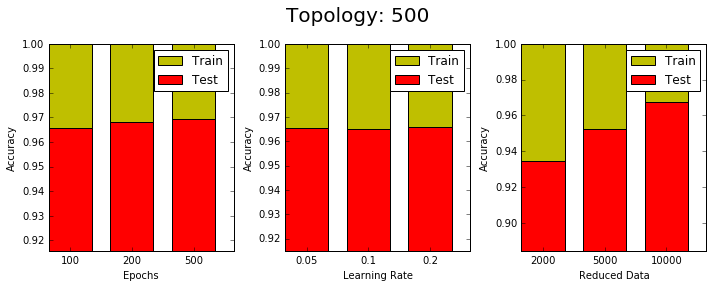

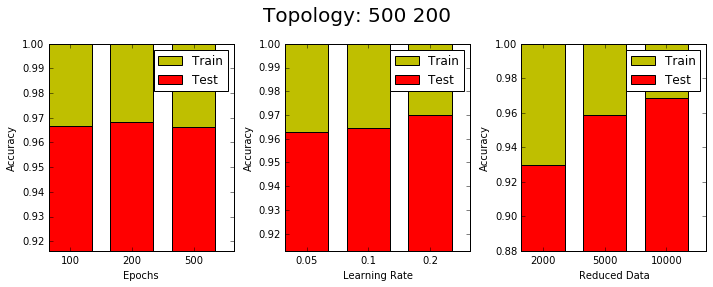

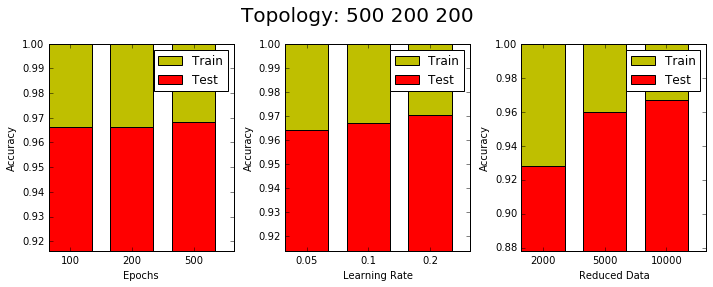

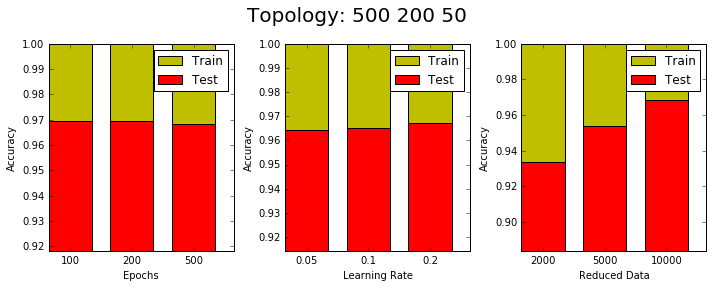

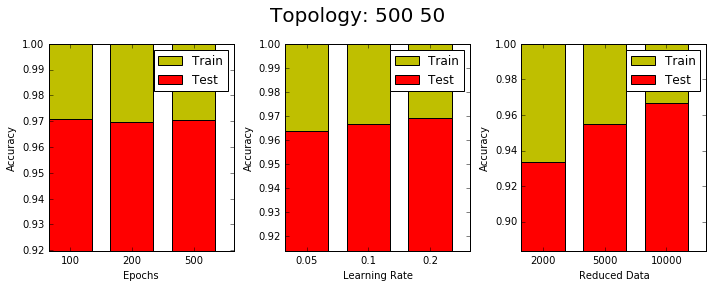

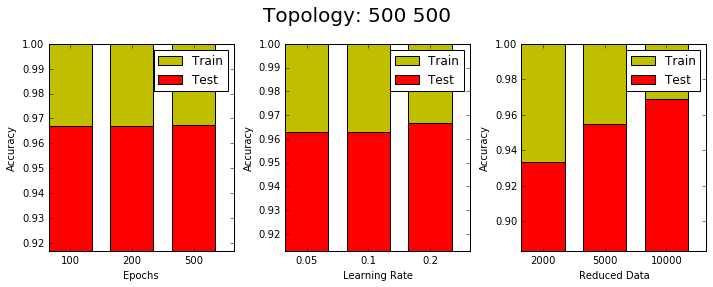

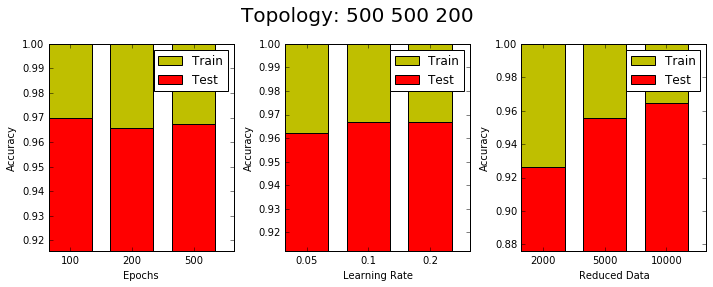

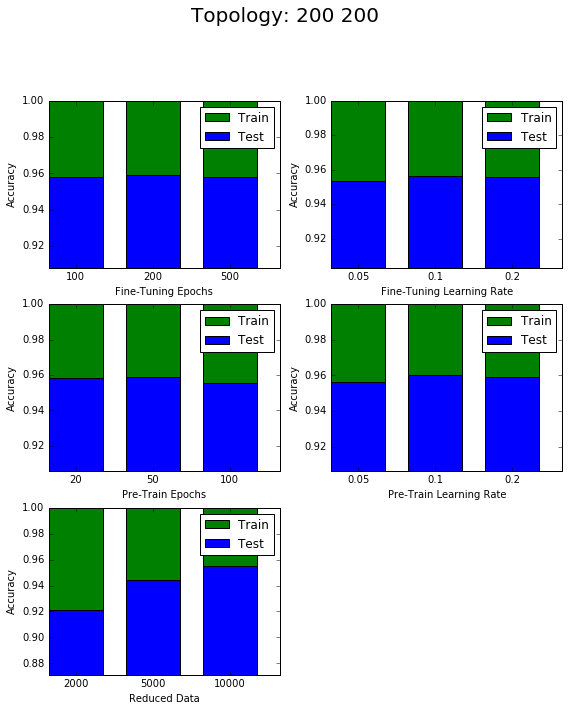

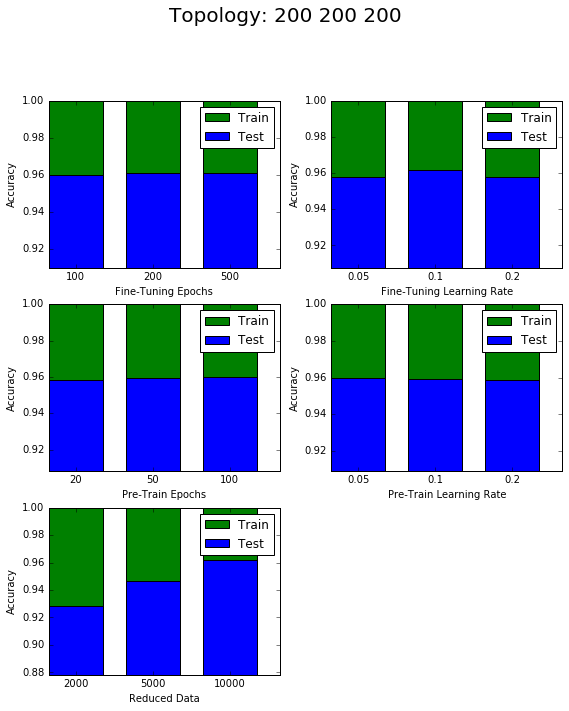

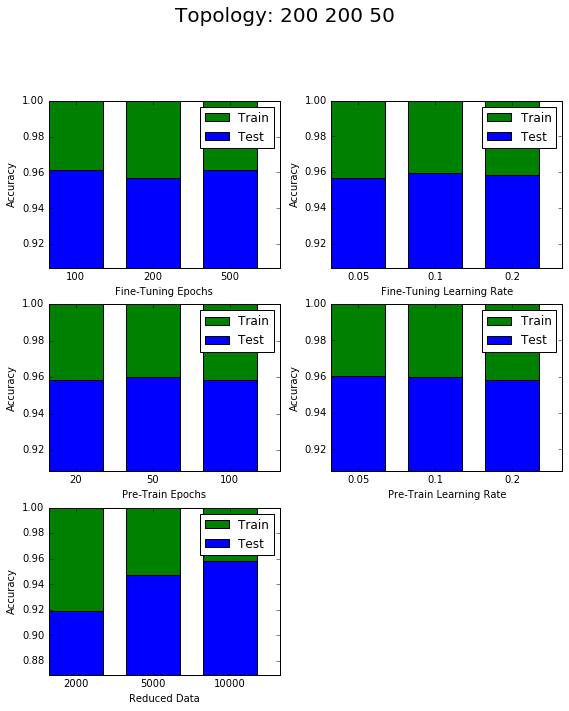

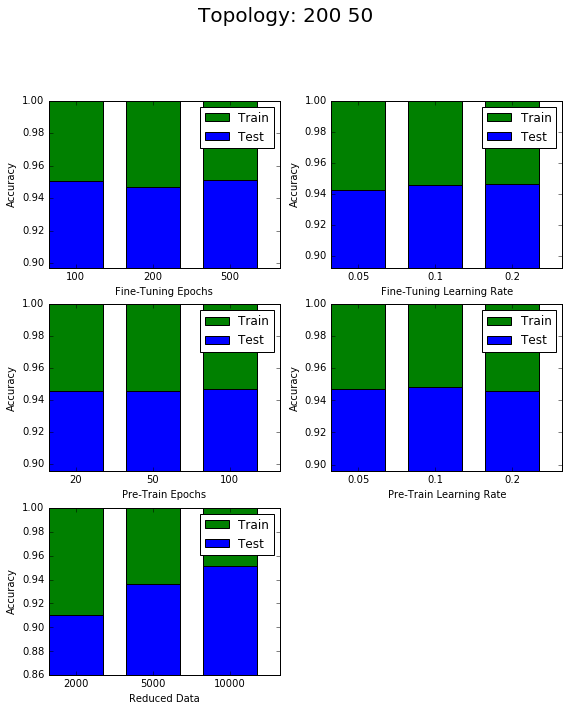

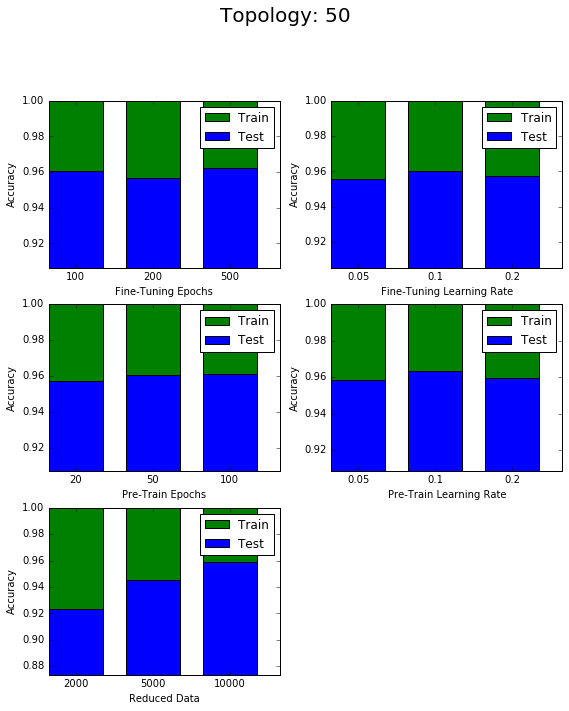

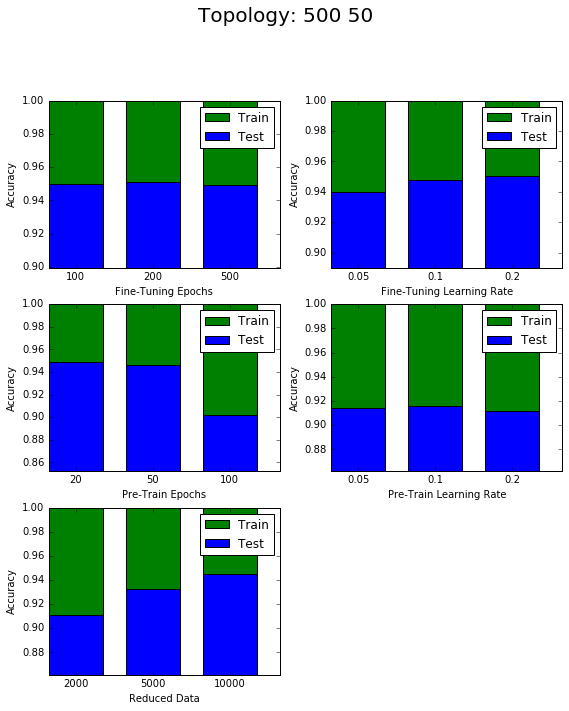

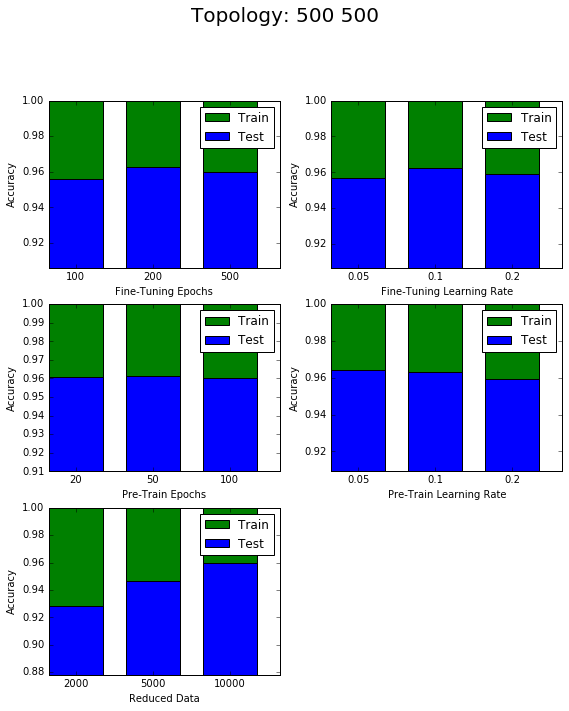

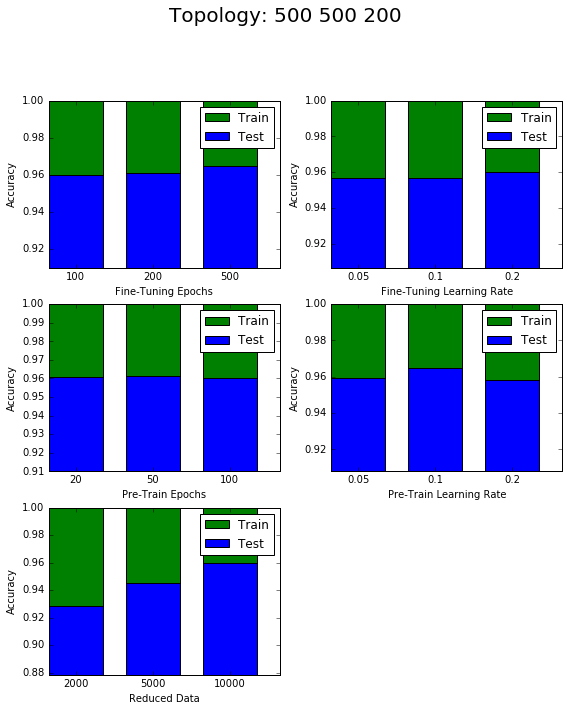

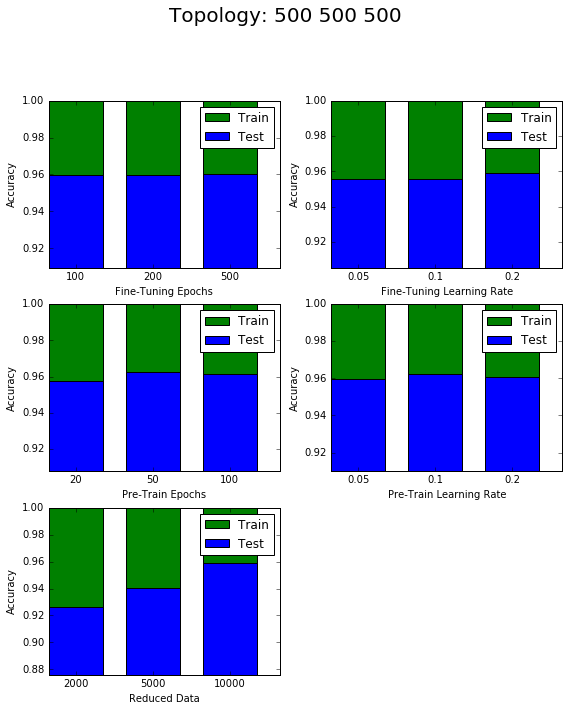

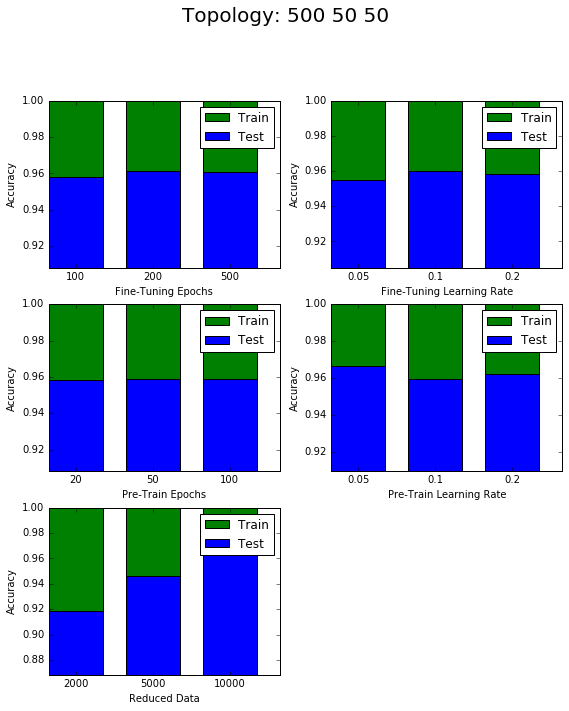

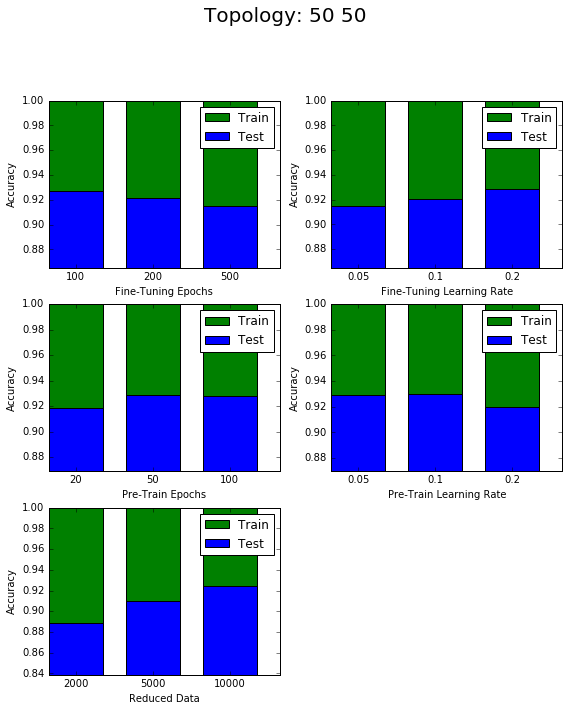

In [392]:
r1 = '.'+os.path.sep+'results'
generateBarPlots(r1)

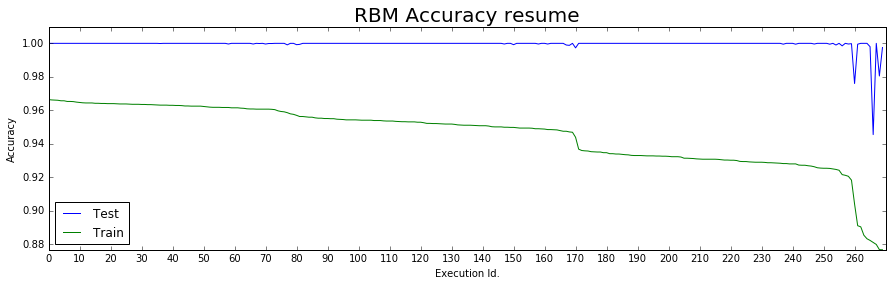

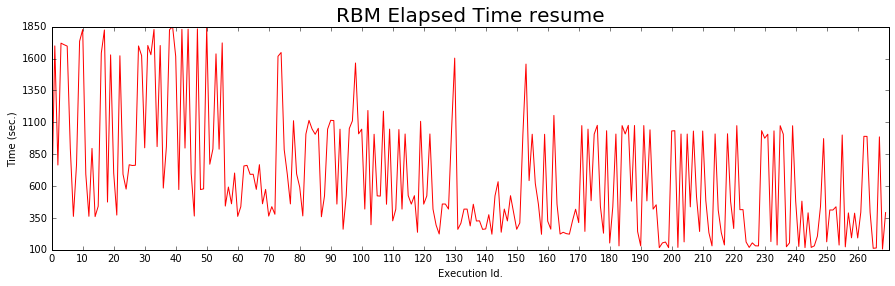

In [395]:
r2 = '.'+os.path.sep+'500-500-500'
generateLinePlots(r2)